# Class Imbalance

---

비즈니스 상황에서 타겟 클래스의 불균형은 굉장히 흔한 현상
> * 고객 이탈 예측 : 잔존 > 이탈
* 금융 비정상 거래 예측 : 정상 > 비정상(사기거래)
* 제조 공정간 불량 예측 : 정상 > 불량


* 이번 단원에서는 Class Imbalance 상황에 대해서 살펴보는 것을 중점으로 둡니다.
* 그래서, train과 validation 혹은 test 구분 하지 않고 진행합니다.

## 1.환경 준비

### 1.1 라이브러리

In [83]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

### 1.2 데이터만들기

In [202]:
seed = 28

x, y = make_classification(n_samples=1000,
                        n_features=2, 
                        n_redundant=0, 
                        weights = [0.95, 0.05],  # class 0과 1의 비율 조정 ==> class imbalance 상황만들기
                        n_clusters_per_class=1, 
                        random_state=seed)

### 1.3 필요한 함수 만들기

* 데이터 분포 시각화 함수

In [226]:
def my_scatter(x, y) :

    # y가 넘파이 이므로 시리즈로 변환하고 클래스별 갯수 세기
    temp = pd.Series(y).value_counts()

    plt.figure(figsize=(6, 6))
    plt.title(f'0 : {temp[0]},    1 : {temp[1]}')

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)

    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.xlim(-4, 2.2)
    # plt.ylim(-4, 2.2)
    plt.show()

* svm 모델 시각화
    * 아래 모델은 x의 **feauture 수가 2개일 때만 가능**합니다.
    * 모델 두개를 비교 가능.

In [225]:
def svm_visualize(x, y, model1, model2 = 0) :

    xx, yy = np.meshgrid(np.linspace(x[:,0].min(), x[:,0].max(), 50), 
                         np.linspace(x[:,1].min(), x[:,1].max(), 50)) # mesh grid

    # 메쉬 그리드값에 대해 모델 부터 거리 값 만들기.
    Z = model1.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if model2 != 0 : # 두번째 모델이 있으면 처리
        Z1 = model2.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z1 = Z1.reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)
    plt.contour(xx, yy, Z, levels=[0], colors = 'gray',linestyles  = '--')

    if model2 != 0 : # 두번째 모델이 있으면 처리
        plt.contour(xx, yy, Z1, levels=[0], colors = 'r',linestyles  = '--')

    plt.axis("tight")
    plt.show()

- 위에서 만든 데이터 분포를 확인합니다.

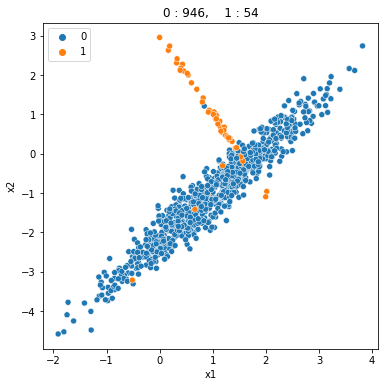

In [227]:
my_scatter(x, y)

## 2.불균형 데이터 그대로 사용하기

### 2.1 데이터 둘러보기

0    948
1     52
dtype: int64


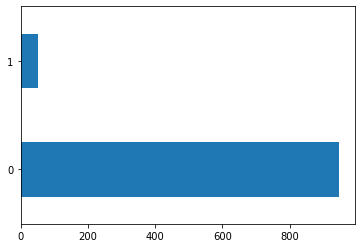

In [178]:
# class imbalance
print(pd.Series(y).value_counts())

pd.Series(y).value_counts().plot(kind = 'barh')
plt.show()

### 2.2 그대로 모델링 수행

In [135]:
from sklearn.svm import SVC
from sklearn.metrics import *

In [205]:
# 모델링 및 평가
model = SVC(kernel='linear')
model.fit(x, y)
pred = model.predict(x)

print(confusion_matrix(y, pred))
print('=' * 55)
print(classification_report(y, pred))

[[940   8]
 [ 19  33]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       948
           1       0.80      0.63      0.71        52

    accuracy                           0.97      1000
   macro avg       0.89      0.81      0.85      1000
weighted avg       0.97      0.97      0.97      1000



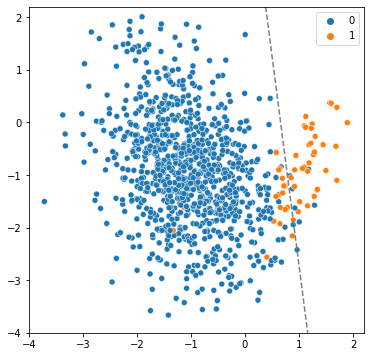

In [213]:
svm_visualize(x,y, model)

## 2.Resampling

In [ ]:
!pip install imblearn

In [66]:
# 필요한 함수들을 불러옵니다.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

### 2.1 Down sampling

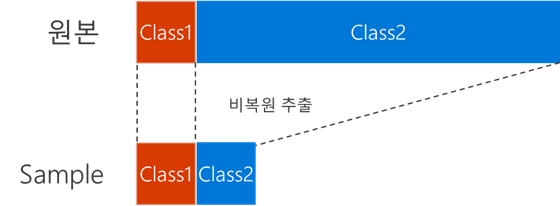

* Down Sampling을 수행하고 데이터 분포를 비교해 봅시다.

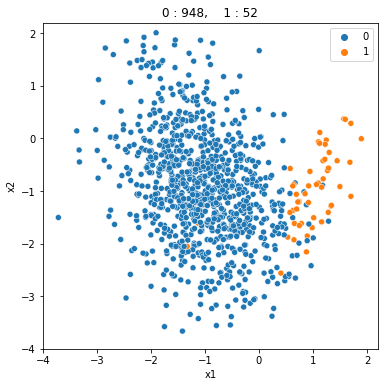

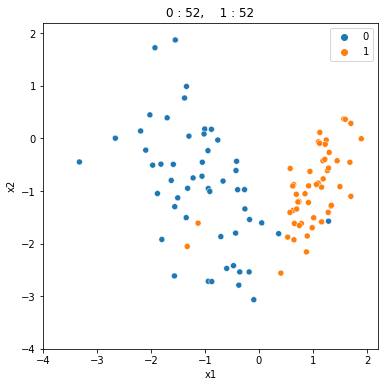

In [214]:
# Down sampling : 적은 쪽 클래스는 그대로, 많은 쪽 클래스는 랜덤 샘플링(적은쪽 클래수 수 만큼)
rus = RandomUnderSampler(random_state = 4)
x_d, y_d = rus.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_d, y_d)

* Down Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

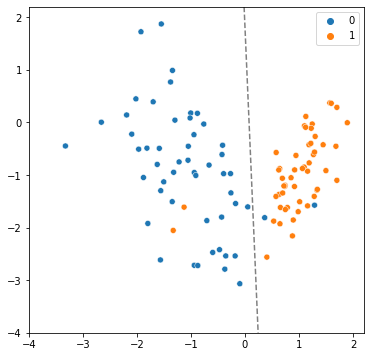

In [216]:
model_d = SVC(kernel='linear')
model_d.fit(x_d,y_d)

svm_visualize(x_d,y_d, model_d)

* 기존 모델과 비교해 봅시다.

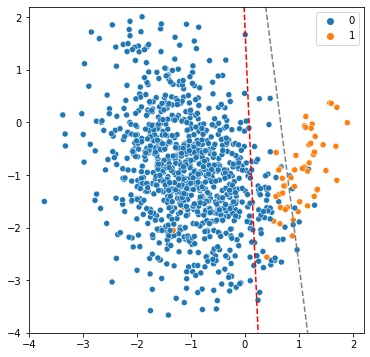

In [217]:
svm_visualize(x,y, model, model_d)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [201]:
# 모델링 및 평가
pred = model_d.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[888  60]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.45      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.79      1000
weighted avg       0.97      0.94      0.95      1000



### 2.2 Up sampling

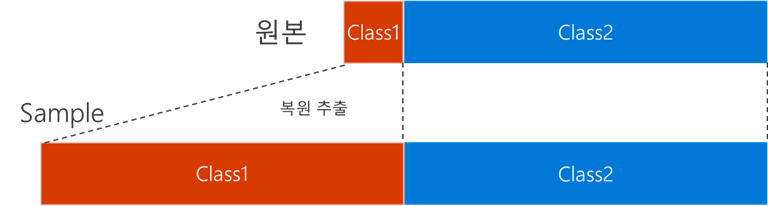

* Up Sampling을 수행하고 데이터 분포를 비교해 봅시다.

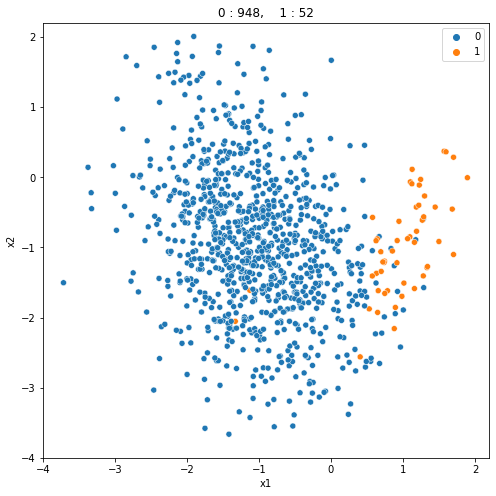

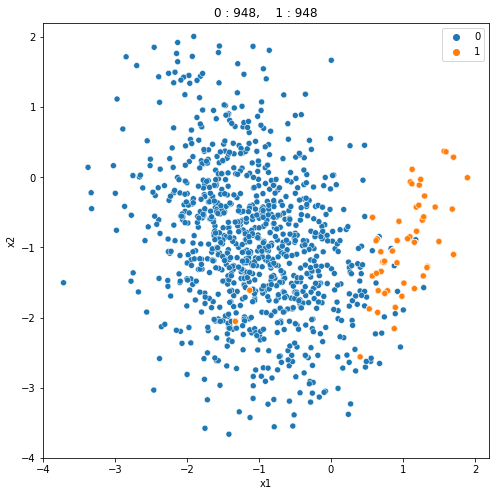

In [188]:
# Up sampling : 많은 클래스는 그대로, 적은 클래스는 랜덤 복원추출(많은 클래스 만큼)
ros = RandomOverSampler(random_state = 4)
x_u, y_u = ros.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_u, y_u)

In [190]:
# 데이터를 열어보면, 클래스 1의 값이 중복으로 추출된 것을 볼수 있습니다.
UpSample = pd.DataFrame(x_u, columns=['x1','x2'])
UpSample['y'] = y_u
UpSample.loc[UpSample['y'] == 1].sort_values('x1')

,x1,x2,y
1675,-1.328629,-2.054089,1
1034,-1.328629,-2.054089,1
1524,-1.328629,-2.054089,1
1375,-1.328629,-2.054089,1
1657,-1.328629,-2.054089,1
...,...,...,...
1789,1.895357,-0.006780,1
1872,1.895357,-0.006780,1
1799,1.895357,-0.006780,1
1883,1.895357,-0.006780,1


In [186]:
# 랜덤 복원 추출을 하다보니, 모든 값이 동일한 수 만큼 추출된 것이 아니라, 각각 다르게 추출됨
UpSample.loc[UpSample['y'] == 1].value_counts()

x1         x2         y
 0.894752  -1.855946  1    28
 0.785587  -1.618389  1    25
 0.574446  -1.407863  1    24
 0.697953  -1.342480  1    24
 0.405838  -2.561105  1    23
 1.571462   0.370428  1    23
 1.499472  -0.916432  1    23
 1.096105  -0.849348  1    23
 1.895357  -0.006780  1    22
 1.226977  -0.111816  1    22
 0.879246  -2.158189  1    22
 0.643148  -0.878539  1    22
 1.282513  -1.406968  1    21
 1.333153  -1.287846  1    21
 1.288207  -0.564498  1    21
 1.127556   0.112743  1    20
 0.626623  -0.904875  1    20
 1.702421  -1.101668  1    20
 0.853566  -1.051973  1    19
 1.598135   0.362476  1    19
 1.188926  -0.770098  1    19
 1.159467  -1.587275  1    19
 0.985638  -1.697665  1    19
 1.245931  -0.031008  1    18
 1.447459  -0.425332  1    18
 1.300197  -0.267356  1    18
-1.328629  -2.054089  1    18
 0.919813  -0.903274  1    18
-1.127272  -1.611335  1    17
 0.577839  -0.572423  1    17
 0.648435  -1.927372  1    17
 0.656499  -1.617329  1    17
 0.692529  -1.06

* UP Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

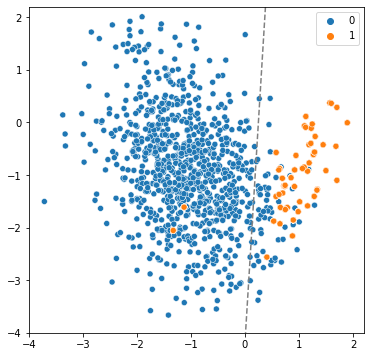

In [218]:
model_u = SVC(kernel='linear')
model_u.fit(x_u,y_u)

svm_visualize(x_u,y_u, model_u)

* 기존 모델과 비교해 봅시다.

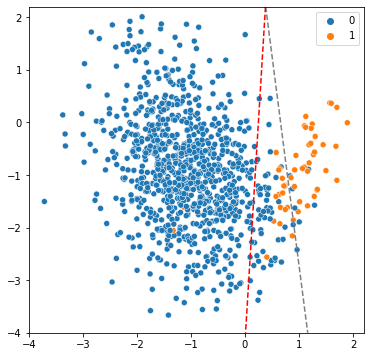

In [219]:
svm_visualize(x,y, model, model_u)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [222]:
# 모델링 및 평가
pred = model_u.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[888  60]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.45      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.79      1000
weighted avg       0.97      0.94      0.95      1000



### 2.3 SMOTE(**S**ynthetic **M**inority **O**versampling **TE**chnique)

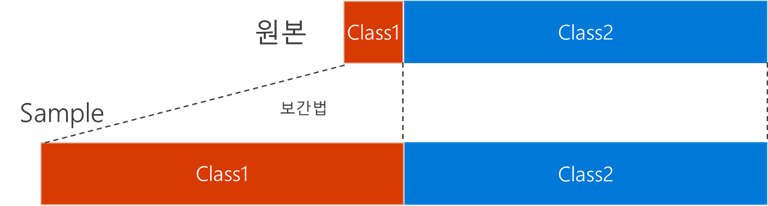

* SMOTE Sampling을 수행하고 데이터 분포를 비교해 봅시다.

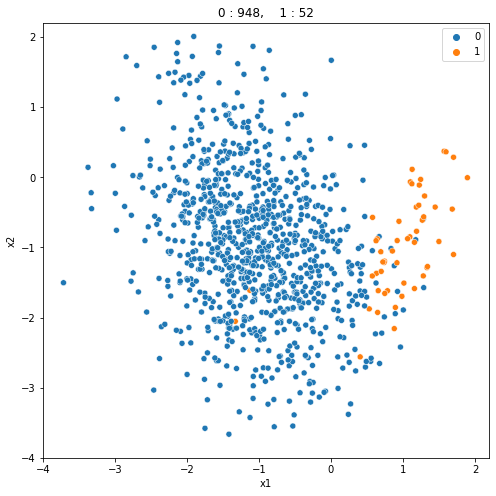

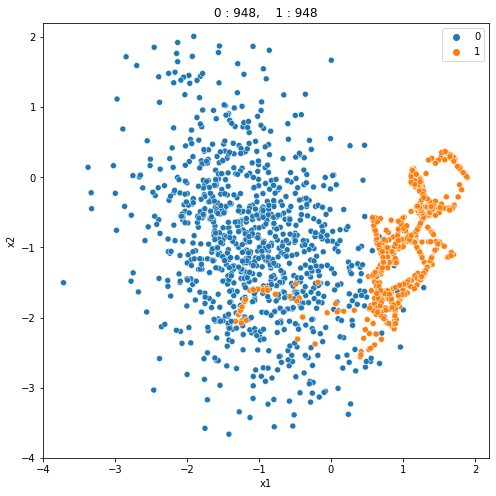

In [193]:
# SMOTE : 많은쪽은 그대로(혹은 약간 down sampling), 적은쪽은 보간법!
smote = SMOTE(random_state = 4) # k_neighbors의미 확인
x_sm, y_sm = smote.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_sm, y_sm)

In [194]:
# 데이터를 열어보면 값들이 보간법으로 생성된 것을 볼수 있다.
SMOTESample = pd.DataFrame(x_sm.copy(), columns=['x1','x2'])
SMOTESample['y'] = y_sm
SMOTESample.loc[SMOTESample['y'] == 1].sort_values('x1')

,x1,x2,y
778,-1.328629,-2.054089,1
1030,-1.285328,-1.958878,1
1158,-1.264018,-1.912021,1
1474,-1.257227,-1.897089,1
1339,-1.252486,-1.886662,1
...,...,...,...
1003,1.854019,0.055761,1
1314,1.865662,0.038147,1
1369,1.868617,0.026440,1
1378,1.884133,0.010201,1


* SMOTE Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

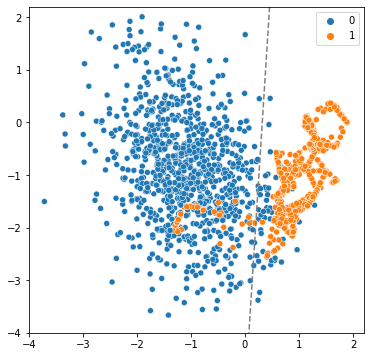

In [220]:
model_sm = SVC(kernel='linear')
model_sm.fit(x_sm,y_sm)

svm_visualize(x_sm,y_sm, model_sm)

* 기존 모델과 비교해 봅시다.

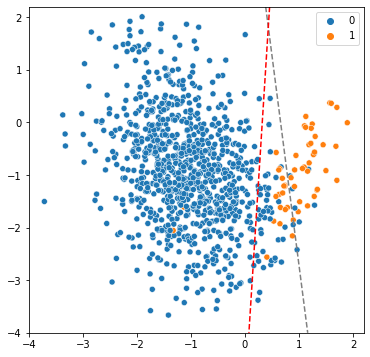

In [221]:
svm_visualize(x,y, model, model_sm)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [223]:
# 모델링 및 평가
pred = model_sm.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[895  53]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.49      0.96      0.65        52

    accuracy                           0.94      1000
   macro avg       0.74      0.95      0.81      1000
weighted avg       0.97      0.94      0.95      1000



## 3.실습

* 새로운 데이터를 생성하시오.
    * seed 값을 조절하여 적절한 데이터를 생성합니다.
* 모델1 : 데이터 그대로 SVC(kernel = 'linear') 모델링을 수행합니다.
    * x, y로 모델링
    * 모델 시각화
    * x로 예측하고, 평가해보기
* 모델2 : Resampling 기법중 하나를 선정하고, 모델링을 수행합니다.
    * resampling x, y로 모델링
    * 모델 시각화 : 모델1, 모델2 비교
    * x로 예측하고, 평가해보기

### 3.1 데이터 만들기

* 새로운 데이터를 생성하시오.
    * seed 값을 조절하여 적절한 데이터를 생성합니다.

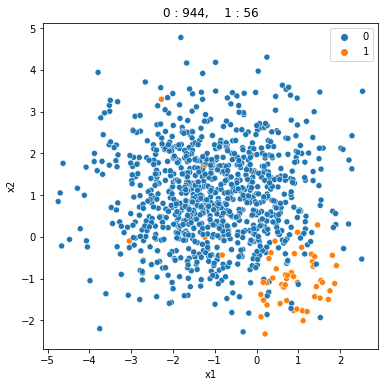

In [237]:
seed = 100

x, y = make_classification(n_samples=1000,
                        n_features=2, 
                        n_redundant=0, 
                        weights = [0.95, 0.05],  # class 0과 1의 비율 조정 ==> class imbalance 상황만들기
                        n_clusters_per_class=1, 
                        random_state=seed)

my_scatter(x,y)

### 3.2 모델1 : 불균형데이터

* 모델1 : 데이터 그대로 SVC(kernel = 'linear') 모델링을 수행합니다.
    * x, y로 모델링
    * 모델 시각화
    * x로 예측하고, 평가해보기

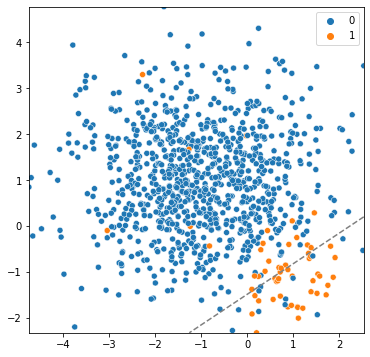

In [238]:
# 모델링 및 평가
model1 = SVC(kernel='linear')
model1.fit(x, y)

svm_visualize(x,y, model1)

In [246]:
pred1 = model1.predict(x)

print(confusion_matrix(y, pred1))
print('=' * 55)
print(classification_report(y, pred1))

[[932  12]
 [ 26  30]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       944
           1       0.71      0.54      0.61        56

    accuracy                           0.96      1000
   macro avg       0.84      0.76      0.80      1000
weighted avg       0.96      0.96      0.96      1000



### 3.3 모델2 : Resampling
* 모델2 : Resampling 기법중 하나를 선정하고, 모델링을 수행합니다.
    * resampling x, y로 모델링
    * 모델 시각화 : 모델1, 모델2 비교
    * x로 예측하고, 평가해보기

In [240]:
ros = RandomUnderSampler()
x_d, y_d = ros.fit_resample(x, y)

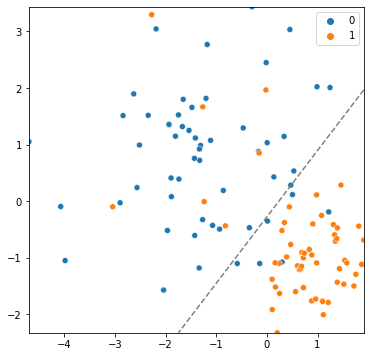

In [241]:
# 모델링 및 평가
model2 = SVC(kernel='linear')
model2.fit(x_d, y_d)
svm_visualize(x_d,y_d, model2)

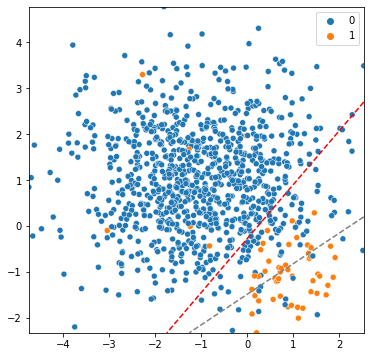

In [242]:
svm_visualize(x,y, model1, model2)

In [244]:
pred2 = model2.predict(x)

print(confusion_matrix(y, pred2))
print('=' * 55)
print(classification_report(y, pred2))

[[863  81]
 [  7  49]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       944
           1       0.38      0.88      0.53        56

    accuracy                           0.91      1000
   macro avg       0.68      0.89      0.74      1000
weighted avg       0.96      0.91      0.93      1000

